In [129]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import interpolate 
from astropy.convolution import convolve_fft, CustomKernel, convolve
from astropy import units as u
from astropy import constants as const
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.fitting.continuum import fit_continuum
from astropy.nddata import StdDevUncertainty
from scipy.special import wofz
from astropy.modeling import models
c = 2.99792458e10 # cm/s, speed of light
k = 1.38064852e-16# cgs, Boltzmann constant
m = 1.9944235e-23
h = 6.62606876e-27

In [ ]:
# Make sure you have scipy, astropy, and specutils installed

In [130]:
# We will start by extracting data from three HST files within the wavelength range (1400-3000)
# I have selected this range as we will fit a CI triplet at 1613

# Function to extract desired data from HST FITS file
def extract_data(file_path, order_index, wavelength_range):
    x1ddata = fits.getdata(file_path, ext=1)
    wave = x1ddata[order_index]['WAVELENGTH']
    flux = x1ddata[order_index]['FLUX']
    err = x1ddata[order_index]['ERROR']
    index = np.where((wave > wavelength_range[0]) & (wave < wavelength_range[1]))[0]
    return np.take(flux, index), np.take(wave, index), np.take(err, index)

# File paths to the three HST files 
file_paths = [
    '/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v08030_x1d.fits',
    '/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v08020_x1d.fits',
    '/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v08010_x1d.fits'
]

# I'm only extracting the data from the sixth order in a certain wavelength range
# Depending on the absorption lines you want to fit you might need to change these values
order_index = 6
wavelength_range = [1400, 3000]

# Extract data from files
flux_data = []
lambda_data = []
yerr_data = []
for file_path in file_paths:
    flux, wavelength, yerr = extract_data(file_path, order_index, wavelength_range)
    flux_data.append(flux)
    lambda_data.append(wavelength)
    yerr_data.append(yerr)

# Average the three files together
flux_data_avg = np.average(flux_data, axis=0)
lambda_data_avg = np.average(lambda_data, axis=0)
yerr_data_avg = np.sqrt(np.sum(np.square(yerr_data), axis=0)) / 2


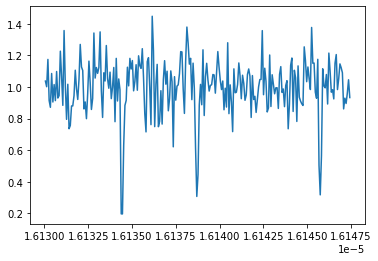

In [131]:
# We need to fit the continuum around the CI triplet
# Start by finding the line free regions of the spectrum around the CI triplet
# Define the selected line free regions in wavelength_ranges

wavelength_ranges = [(1613, 1613.7), (1613.7, 1614.2), (1614.2, 1614.75)]
flux_data_normalized = []
lambda_data_normalized = []
yerr_data_normalized = []

# For each region in wavelength_ranges grab the region from the spectrum
for wavelength_range in wavelength_ranges:
    min_wavelength, max_wavelength = wavelength_range

    index = np.where((lambda_data_avg > min_wavelength) & (lambda_data_avg < max_wavelength))[0]
    flux_data_range = np.take(flux_data_avg, index)
    lambda_data_range = np.take(lambda_data_avg, index)
    yerr_data_range = np.take(yerr_data_avg, index)

    if len(lambda_data_range) == 0:
        continue
    
    # We then fit the continuum using a sixth order polynomial 
    spectrum = Spectrum1D(flux=flux_data_range *u.erg*u.cm**-2*u.s**-1*u.A**-1, spectral_axis=lambda_data_range * u.AA, uncertainty=StdDevUncertainty(yerr_data_range))
    fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(6), window=[(min_wavelength * u.AA, max_wavelength * u.AA)])
    y_fit = fitted_continuum(lambda_data_range * u.AA)

    # Normalize the region
    spec_normalized = spectrum / y_fit
    lambda_data_normalized.append(spec_normalized.spectral_axis)
    flux_data_normalized.append(spec_normalized.flux)
    yerr_data_normalized.append((yerr_data_range/y_fit)/(u.erg**-1*u.A*u.cm**2*u.s))

# Add sections back together
lambda_data_normalized = np.concatenate(lambda_data_normalized)*1e-8
flux_data_normalized = np.concatenate(flux_data_normalized)
yerr_data_normalized = np.concatenate(yerr_data_normalized)

# We now have a normalized spectrum
plt.plot(lambda_data_normalized, flux_data_normalized)


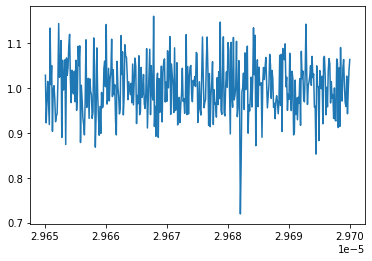

In [132]:
# We will also fit a CI doublet 
# We need to extract data from a different HST FITS file
# As we don't have to average files together I will extract the line free sections to fit the continuum
file = ['/Users/aoifebrennan/HST_project/HST_data/HST_data/oe4v10030_x1d.fits']
date = ['FUV']
colors = ['royalblue']

# Line free regions around the doublet that we want to extract
wavelength_ranges = [(2965, 2966.65), (2966.65, 2968), (2968, 2970)]
flux_data_list = []
lambda_data_list = []
yerr_data_list = []

plt.figure()
for i, file_name in enumerate(file):
    x1ddata = fits.getdata(file_name, ext=1)
    wave = x1ddata[:]['WAVELENGTH']
    flux = x1ddata[:]['FLUX']
    err = x1ddata[:]['ERROR']

    # For each region extract the data
    for j, wavelength_range in enumerate(wavelength_ranges):
        min_wavelength, max_wavelength = wavelength_range

        index = np.where((wave[6] > min_wavelength) & (wave[6] < max_wavelength))[0]
        flux_data = np.take(flux[6], index)
        lambda_data = np.take(wave[6], index)
        yerr_data = np.take(err[6], index)

        # Fit the continuum using a third order polynomial
        spectrum = Spectrum1D(flux=flux_data * u.erg * u.cm**-2 * u.s**-1 * u.A**-1, spectral_axis=lambda_data * u.AA)
        fitted_continuum = fit_continuum(spectrum, models.Polynomial1D(3))
        y_fit = fitted_continuum(lambda_data * u.AA)

        # Normalise the spectrum
        spec_normalized = spectrum / y_fit
        lambda_data_normalized = spec_normalized.spectral_axis
        flux_data_normalized = spec_normalized.flux
        yerr_data_normalized = (yerr_data / y_fit) / (u.erg**-1 * u.A * u.cm**2 * u.s)

        flux_data_list.append(flux_data_normalized)
        lambda_data_list.append(lambda_data_normalized)
        yerr_data_list.append(yerr_data_normalized)

# Add the sections back together
lambda_data_2960 = np.concatenate(lambda_data_list)*1e-8
flux_data_2960 = np.concatenate(flux_data_list)
yerr_data_2960 = np.concatenate(yerr_data_list)

plt.plot(lambda_data_2960, flux_data_2960)

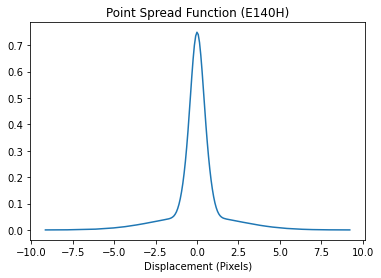

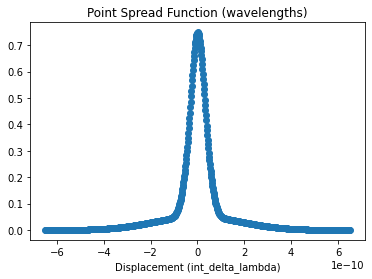

In [133]:
# To simulate absorption lines we need the spectral response of the instrument that was used
# In this example the CI triplet was observed by the STIS instrument in combination with the E140H grating

# First get pixel_location and spectral_response from PSF file
pixel_location, spectral_response = [], []
for line in open('/Users/aoifebrennan/HST_project/HST_data/PSF/PSF_1500.txt', 'r'):
  values = [float(s) for s in line.split()]
  pixel_location.append(values[0])
  spectral_response.append(values[2])

# Create lists for both and plot
pixel_location = np.array(pixel_location)
spectral = np.array(spectral_response)
plt.plot(pixel_location, spectral)
plt.title('Point Spread Function (E140H)')
plt.xlabel('Displacement (Pixels)')
plt.show()
stepsize = (lambda_data_1613[1]-lambda_data_1613[0])/u.AA

# Currently we have pixel location in terms of the displacement of pixels
# We want displacement in terms of delta_lambda (interger)
# You might want to change psffinewav depenging on the coarse wavelength grid you use to simulate absorption lines
for i in (pixel_location):
    psfcoarsewav = (pixel_location)*stepsize
psffinewav=np.arange(np.floor(len(psfcoarsewav)*(psfcoarsewav[1]-psfcoarsewav[0])/10**-11.8))*10**-11.8+pixel_location[0]*stepsize

# Interpolate to find the spectral reponse at each interger value of displacement (delta_lambda)
interpol_function = scipy.interpolate.interp1d(psfcoarsewav, spectral)
interpolated_spectral_response = interpol_function(psffinewav)

plt.plot(psffinewav, interpolated_spectral_response, 'o')
plt.title('Point Spread Function (wavelengths)')
plt.xlabel('Displacement (int_delta_lambda)')

# Create kernel that will be used for convolution
kernel_1613 = CustomKernel(interpolated_spectral_response) 

In [134]:
# The CI doublet was observed by STIS in combination using the E230H grating
# We repeat the above steps for the E230H grating

pixel_location, spectral_response = [], []
for line in open('/Users/aoifebrennan/HST_project/HST_data/PSF/E230H.txt', 'r'):
  values = [float(s) for s in line.split()]
  pixel_location.append(values[0])
  spectral_response.append(values[2])

stepsize = (lambda_data_2960[1]-lambda_data_2960[0])/u.cm
pixel_location = np.array(pixel_location)
spectral = np.array(spectral_response)
psfcoarsewav = pixel_location*stepsize
psffinewav = np.arange(np.floor(len(psfcoarsewav)*(psfcoarsewav[1]-psfcoarsewav[0])/10**-10.4))*10**-10.4+pixel_location[0]*stepsize
interpol_function = scipy.interpolate.interp1d(psfcoarsewav, spectral)
interpolated_spectral_response = interpol_function(psffinewav)
kernel_2960 = CustomKernel(interpolated_spectral_response)

In [135]:
# Define wavelength grid to simulate absorption lines
Lambda_1613 = np.arange(1613*10**-8, 1615*10**-8, 10**-11.8) 
Lambda_2960 = np.arange(2960*10**-8, 2975*10**-8, 10**-10.8) 

# Define energy levels and weights for both the CI doublet at 2960 and the CI triplet at 1613
# I took these values from the NIST database, you could also input these values as .txt files if you're fitting alot of lines
Energy_1613 = [0, 16.4167130, 43.4134567]
Weights_1613 = [1, 3, 5]

Energy_2960 = [16.4167130, 43.4134567]
Weights_2960 = [3, 5]


# Function to simulate absoprtion lines
# Inputs: Lambda (Array of wavelengths used to simulate absorption lines)
#         lambda0 (wavelength of transition)
#         i (integer number of transition)
#         A21 (Einstein coefficient)
#         g2 and g1 (weights of the transtion)
#         log_N (log of column density)
#         E (energy levels)
#         g (weigths)
#         f (oscillator strengths)
#         T (temperature)

# wavelegths unit = (cm), column density unit = (cm^-2), temperature unit = (K)
# Depending on what lines you want to simulate you need to change the function inputs
# All inputs except (Lambda, log_N, i and T) can be found in line databases for example NIST or MOLAT
# A detailed explaination on the equations used in the absorption model can be found at https://casper.astro.berkeley.edu/astrobaki/index.php/Radiative_Processes_in_Astrophysics

def absorption_model(Lambda, lambda0, i, A21, g2, g1, log_N, E, g, f, T):
   
    N = float(10**log_N)
    freq = (c/Lambda)
    freq_0 = (c/lambda0)
    
    # if the oscillator strength is given create Gaussian line profile
    if (A21 is None):
        doppler_width = ((freq_0)/c)*(np.sqrt((2*k*T)/m))
        line_profile = (1/(doppler_width*np.sqrt(np.pi)))*np.exp(-(((freq-freq_0)**2)/(doppler_width**2)))        
    else:
        # if the einstein coefficient is given calculate the doppler width and create the Voigt line profile
        doppler_width = ((freq_0)/c)*(np.sqrt((2*k*T)/m))
        alpha = np.sqrt(np.log(2))*doppler_width
        gamma = (A21/(4*np.pi))
        sigma = (alpha/np.sqrt(2*np.log(2)))
        line_profile = np.real(((wofz(((freq-freq_0)+1j*gamma)/sigma/np.sqrt(2)))/sigma/np.sqrt(2*np.pi)))
    
   
    kT = (.695*T)
    energy= []
    for j in (E):
        energy.append(np.exp(-j/(kT)))
 
    #calculate the fractional population (x)
    Z = np.sum( np.multiply(energy,g))
    x = ((g1)*(np.exp(-E[i]/kT)))/Z
  
    # if oscillator strengths are not given calculate the cross sections
    if (f is None):
        B12 = (g2/g1)*((A21*c**2)/(2*h*freq_0**3))
        cross_section = B12*freq*h/4*np.pi
    # if oscillator strengths are given calculate cross sections (note: this conversion is for oscillator strengths taken from the MOLAT database)
    else:
        cross_section = f*.0265
    Depth = (N*cross_section*x*line_profile)
    Intensity = 1*(np.exp(-(Depth)))
  
    #return simulated absoprtion line
    return(Intensity)

In [136]:
# We can now fit simulated absorption lines to HST data using a Bayesian Markov Chain Monte Carlo (MCMC) approach.
# For information on the emcee implementation of MCMC visit https://emcee.readthedocs.io/en/stable/

def log_likelihood(theta, lambda_data_2960, flux_data_2960, yerr_data_2960, lambda_data_1613, flux_data_1613, yerr_data_1613):
    # Our free parameters that we wish to fit are the temperature, log column density and radial velocity
    T, log_N, Rad_V = theta
   
    # Simulate absoprtion lines by calling the absorption_model for each line
    # If lots of transtions are being fitted (ie. bands) you'll need to give inputs as lists
    Transition_1 = absorption_model(Lambda_1613, 1613.37599e-8, 0, 3.6e+04, 3, 1, log_N, Energy_1613, Weights_1613, None, T)        
    Transition_2 = absorption_model(Lambda_1613, 1613.80343e-8, 1, 2.8e+04, 3, 3, log_N, Energy_1613,  Weights_1613, None, T)
    Transition_3 = absorption_model(Lambda_1613, 1614.50683e-8, 2, 3e+04, 3, 5, log_N, Energy_1613,  Weights_1613, None, T)  
    Transition_4 = absorption_model(Lambda_2960, 2965.7130e-8, 0, None, 5, 3, log_N, Energy_2960, Weights_2960, 1.9e-08,  T)         
    Transition_5 = absorption_model(Lambda_2960, 2968.0894e-8, 1, None, 5, 5, log_N, Energy_2960, Weights_2960, 2.8e-08,  T)  
    
    # Function to convolve PSF with the simulated absorption line
    def get_convolved_model(Lambda, Transition, kernel):
        delta_lambda = (Rad_V * 100000 / c) * Lambda[0]
        Lambda1 = Lambda + delta_lambda
        convolved = convolve_fft(Transition, kernel, boundary='wrap', normalize_kernel=True)
        interpol_function = interp1d(Lambda1, convolved, bounds_error=False, fill_value=1)
        return interpol_function

    # Create model for each transition
    model1 = get_convolved_model(Lambda_2960, Transition_4, kernel_2960)(lambda_data_2960)
    model2 = get_convolved_model(Lambda_2960, Transition_5, kernel_2960)(lambda_data_2960)
    model_a = get_convolved_model(Lambda_1613, Transition_1, kernel_1613)(lambda_data_1613)
    model_b = get_convolved_model(Lambda_1613, Transition_2, kernel_1613)(lambda_data_1613)
    model_c = get_convolved_model(Lambda_1613, Transition_3, kernel_1613)(lambda_data_1613)
    
    sigma2_2960 = yerr_data_2960 ** 2
    sigma2_1613 = yerr_data_1613 ** 2 

    return (-0.5 * np.sum((flux_data_2960 -  model1) ** 2 / sigma2_2960+ np.log(sigma2_2960)))+(-0.5 * np.sum(((flux_data_2960) - model2) ** 2 / sigma2_2960 + np.log(sigma2_2960)))+ (-0.5 * np.sum((flux_data_1613 - model_a) ** 2 / sigma2_1613 + np.log(sigma2_1613)))+(-0.5 * np.sum(((flux_data_1613) - model_b) ** 2 / sigma2_1613 + np.log(sigma2_1613)))+(-0.5 * np.sum(((flux_data_1613) - model_c) ** 2 / sigma2_1613 + np.log(sigma2_1613)))

In [141]:
def log_prior(theta):    
    T, log_N, Rad_V = theta
    # Depending on the system observed you will need to change the parameters for Rad_V
    if 1 < T < 5000 and 1 < log_N < 100 and 11.5 < Rad_V < 13:
        return 0 
    else:
        return -np.inf

def log_probability(theta, lambda_data_2960, flux_data_2960, yerr_data_2960, lambda_data_1613, flux_data_1613, yerr_data_1613):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, lambda_data_2960, flux_data_2960, yerr_data_2960, lambda_data_1613, flux_data_1613, yerr_data_1613
                              )

In [145]:
import emcee
from multiprocessing import Pool

# Code should run fairly quickly on one core if you're only fitting a couple of transitions
pos = np.array([100, 20, 12])+np.random.randn(32,3)*1e-2*np.array([100, 20, 12])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(lambda_data_2960, flux_data_2960, yerr_data_2960, lambda_data_1613, flux_data_1613, yerr_data_1613))
sampler.run_mcmc(pos, 2000, progress=True, skip_initial_state_check=True);

100%|███████████████████████████████████████| 2000/2000 [19:51<00:00,  1.68it/s]


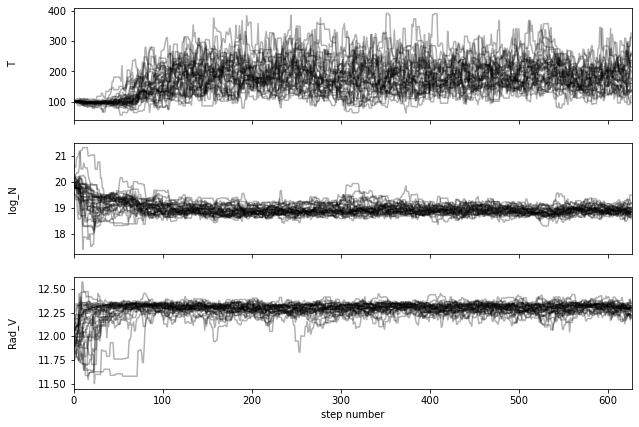

In [143]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["T", "log_N", "Rad_V"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


(16864, 3)


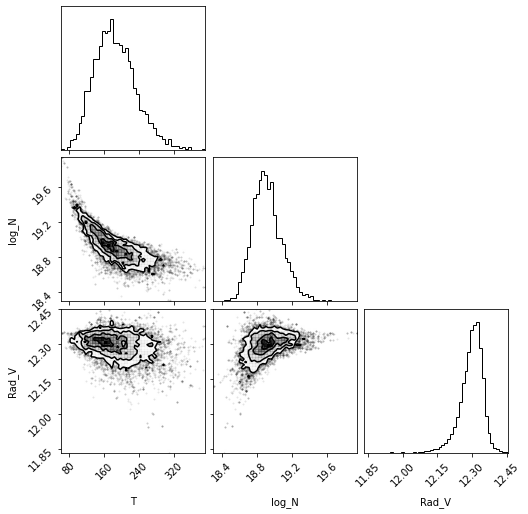

In [144]:
# Make sure you run for long enough and then discard burn-in

flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, bins = 50, 
);
fig.savefig("HD131_C_corner.png")

In [17]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [15, 60, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>